### Adversarial Trained Models Evaluation Metrics

#### AddSent-first (F1) eval

{'squad': [{'eval_exact_match': 75.10879848628193, 'eval_f1': 83.5709325317187, 'eval_bleu': {'bleu': 0.6286765055422094, 'precisions': [0.7469327803697944, 0.6692613448161643, 0.5923214285714286, 0.5275628626692457], 'brevity_penalty': 1.0, 'length_ratio': 1.415029749775858, 'translation_length': 34722, 'reference_length': 24538}}, {'eval_exact_match': 69.54588457899716, 'eval_f1': 78.3012194359963, 'eval_bleu': {'bleu': 0.5814948794698053, 'precisions': [0.7005332012470499, 0.6214896214896215, 0.5463805020007275, 0.4806464981351015], 'brevity_penalty': 1.0, 'length_ratio': 1.3986877496128454, 'translation_length': 34321, 'reference_length': 24538}}, {'eval_exact_match': 67.89025543992432, 'eval_f1': 76.54895284097668, 'eval_bleu': {'bleu': 0.5416197853043556, 'precisions': [0.6674696095456837, 0.5826436415724973, 0.5047511948271015, 0.43839563272423987], 'brevity_penalty': 1.0, 'length_ratio': 1.4549678050370853, 'translation_length': 35702, 'reference_length': 24538}}], 'adv_addOneS

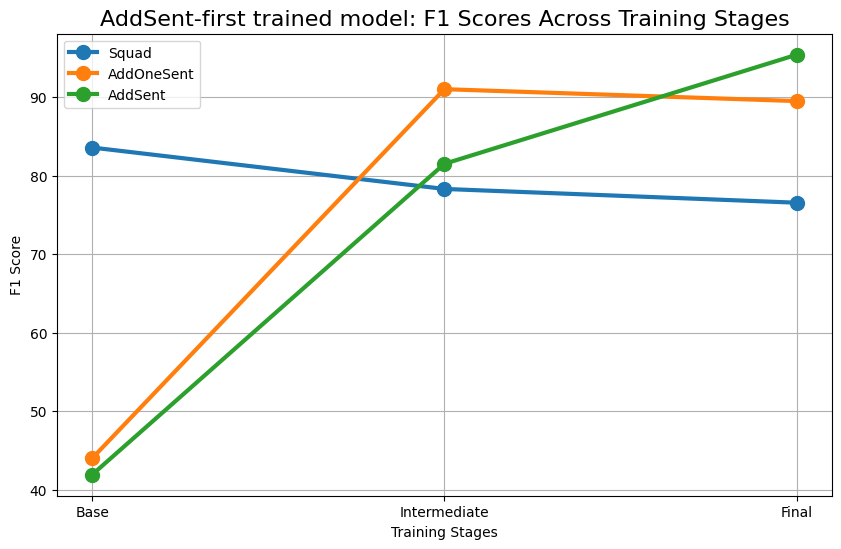

In [ ]:
import json
import matplotlib.pyplot as plt

def plot_f1_training_stages(title, eval_file_path):
    # Load the data from the JSON file
    with open(eval_file_path, 'r') as file:
        data = json.load(file)
        print(data)

    # Extract the F1 scores for each dataset
    squad_f1 = [entry['eval_f1'] for entry in data['squad']]
    addOneSent_f1 = [entry['eval_f1'] for entry in data['adv_addOneSent']]
    addSent_f1 = [entry['eval_f1'] for entry in data['adv_addSent']]

    # Define the stages
    stages = ['Base', 'Intermediate', 'Final']

    # Plot the F1 scores
    plt.figure(figsize=(10, 6))
    plt.plot(stages, squad_f1, marker='o', label='Squad', linewidth=3, markersize=10)
    plt.plot(stages, addOneSent_f1, marker='o', label='AddOneSent', linewidth=3, markersize=10)
    plt.plot(stages, addSent_f1, marker='o', label='AddSent', linewidth=3, markersize=10)

    # Add titles and labels
    plt.title(title, fontsize=16)
    plt.xlabel('Training Stages')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_f1_training_stages('AddSent-first trained model: F1 Scores Across Training Stages', './new_eval_outputs/addSent_first_eval_metrics.json')

#### AddOneSent-first (F1) eval

{'squad': [{'eval_exact_match': 75.10879848628193, 'eval_f1': 83.5709325317187, 'eval_bleu': {'bleu': 0.6286765055422094, 'precisions': [0.7469327803697944, 0.6692613448161643, 0.5923214285714286, 0.5275628626692457], 'brevity_penalty': 1.0, 'length_ratio': 1.415029749775858, 'translation_length': 34722, 'reference_length': 24538}}, {'eval_exact_match': 71.84484389782403, 'eval_f1': 80.29227417072639, 'eval_bleu': {'bleu': 0.5902533123661899, 'precisions': [0.7136941560713869, 0.6328724390860805, 0.5536894440065482, 0.4853546157643574], 'brevity_penalty': 1.0, 'length_ratio': 1.3975059092020539, 'translation_length': 34292, 'reference_length': 24538}}, {'eval_exact_match': 68.39167455061495, 'eval_f1': 77.31410334600021, 'eval_bleu': {'bleu': 0.548411507209988, 'precisions': [0.6769384835479256, 0.5913453650533224, 0.5107855107855108, 0.4423818138912924], 'brevity_penalty': 1.0, 'length_ratio': 1.4243214605917354, 'translation_length': 34950, 'reference_length': 24538}}], 'adv_addOneSe

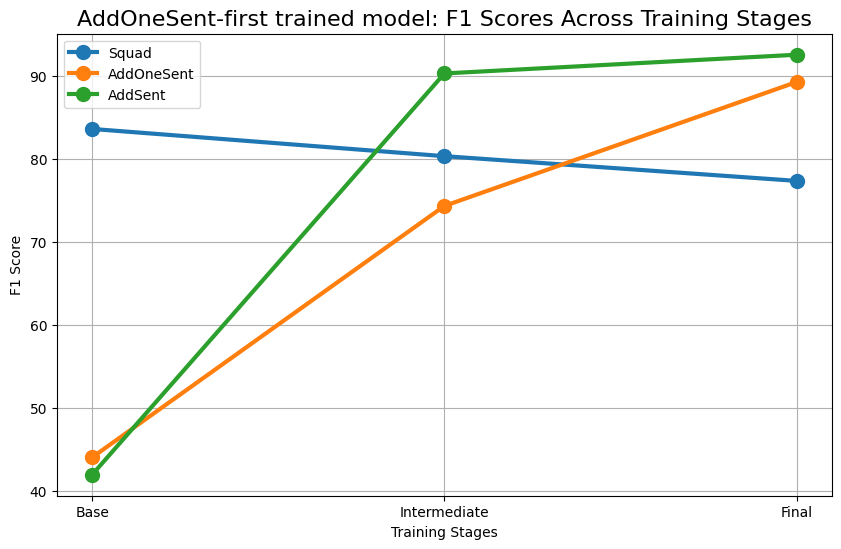

In [22]:
plot_f1_training_stages('AddOneSent-first trained model: F1 Scores Across Training Stages', './new_eval_outputs/addOneSent_first_eval_metrics.json')